# This notebook Implements the Metropolis-Hastings algorithm along with the Gelman-Rubin convergence ratio to determine the mean value of data drawn from two Gaussian distributions. It can be adjusted to find the mean value of just one distribution.



## Importing the necessary libraries and setting up the required constants

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import random as rdn
import pymc as pm
import numpy as np
import scipy.stats as stats
from scipy.stats import norm
from pylab import *
import math

n = 10000      # the number of data points drawn from the Gaussian

step = 10      # the standard deviation of the proposal Gaussian distribution

# The values of the mean and standard deviation of the first Gaussian
sigma = 5      
mu_true = 30   

# The values of the mean and standard deviation of the second Gaussian
mu2 = 0
sigma2 = 5

# Drawing the data points from the 2 probability distributions
data1 = np.random.normal(mu_true, sigma, [n]) 
data2 = np.random.normal(mu2, sigma2, [n])
data  = concatenate((data1,data2))


# Creating the actual Metropolis-Hastings function:

In [32]:
def sampler(data, x_init1, x_init2, x_init3, step):
    """Metropolis-Hastings algorithm:
    Input: 
        data points drawn from probability distribution
        initial position of the first, second and third chain
        the standard deviation of the proposal distribution
        
    Output:
        the trace of the 3 chains
        the acceptance (defined as the number of accepted proposals over the total number of proposals) of the first chain
        (the acceptance of the second and third chains will be approximately the same)
        """
    
    # Initializing the initial points
    x_cur1 = x_init1
    x_cur2 = x_init2
    x_cur3 = x_init3
    
    # Calculating the approximated Gaussian parameters from the sampled data
    m = np.mean(data)
    sigma = np.sqrt(np.sum((data-m)**2)/(len(data)-1))
    
    
    # Initializing the traces of the 3 chains
    print (m, sigma)
    trace_gaus1 = [x_cur1]
    trace_gaus2 = [x_cur2]
    trace_gaus3 = [x_cur3]
    
    k = 0 # acceptance for the first chain
    
    
    R = 2 # variance (arbitrarilly set to be whatever value larger than 1.05 - the condition for the while clause defined downstairs)
    
    
    # Calculating the likelihood of the current point (which will be compared to the likelihood of the proposed point)
    likelihoodcur1  = np.e**(-0.5 * (x_cur1 - m)**2/sigma**2)
    likelihoodcur2  = np.e**(-0.5 * (x_cur2 - m)**2/sigma**2)
    likelihoodcur3  = np.e**(-0.5 * (x_cur3 - m)**2/sigma**2)
      
    # Using a flat prior
    priorcur  = 1
    priorprop = 1   
     
    # Calculating the (unnormalized) probability of the current point (Bayes theorem)
    p_current1  = likelihoodcur1  * priorcur
    p_current2  = likelihoodcur2  * priorcur
    p_current3  = likelihoodcur3  * priorcur
        
    while R > 1.05: # The Gelman - Rubin convergence condition
        
        
        # Sampling a proposal point with a Gaussian distribution with mean=current point and standard deviation=step
        x_prop1 = stats.norm(x_cur1, step).rvs()
        x_prop2 = stats.norm(x_cur2, step).rvs()
        x_prop3 = stats.norm(x_cur3, step).rvs()

        # Calculating the likelihood of the proposed point
        likelihoodprop1 = np.e**(-0.5 * (x_prop1 - m)**2/sigma**2)
        likelihoodprop2 = np.e**(-0.5 * (x_prop2 - m)**2/sigma**2)
        likelihoodprop3 = np.e**(-0.5 * (x_prop3 - m)**2/sigma**2)

        # Calculating the (unnormalized) probability of jumping to the proposal point (Bayes theorem)
        p_proposal1 = likelihoodprop1 * priorprop
        p_proposal2 = likelihoodprop2 * priorprop
        p_proposal3 = likelihoodprop3 * priorprop
        
        # Implementing the Metropolis-Hastings acceptance
        accept1 = np.random.rand() < (p_proposal1/p_current1)
        accept2 = np.random.rand() < (p_proposal2/p_current2)
        accept3 = np.random.rand() < (p_proposal3/p_current3)
    
        
        if accept1:
            # Move to proposed position of the first chain
            x_cur1 = x_prop1  
            k = k + 1
            p_current1 = p_proposal1
        trace_gaus1.append(x_cur1)
        
        if accept2:
            # Move to proposed position of the second chain
            x_cur2 = x_prop2
            p_current2 = p_proposal2
        trace_gaus2.append(x_cur2)
        
        if accept3:
            # Move to proposed position of the third chain
            x_cur3 = x_prop3
            p_current3 = p_proposal3
        trace_gaus3.append(x_cur3)
        
        # Implementing the Gelman-Rubin convergence ratio:
        mean1 = np.mean(trace_gaus1)  
        mean2 = np.mean(trace_gaus2)
        mean3 = np.mean(trace_gaus3)
        
        mean  = (mean1 + mean2 + mean3)/3
        n     = len(trace_gaus1)
        
        s1 = np.sqrt(np.sum((trace_gaus1 - mean1)**2)/(n-1))
        s2 = np.sqrt(np.sum((trace_gaus2 - mean1)**2)/(n-1))
        s3 = np.sqrt(np.sum((trace_gaus3 - mean1)**2)/(n)-1)
        
        w = (s1**2 + s2**2 + s3**2)/3
        b = n * ((mean1 - mean)**2 + (mean2-mean)**2 + (mean3-mean)**2)
        var = w - w/n +b/n
        
        R = np.sqrt(var / w)
        
    print (R, len(trace_gaus1))
    k = k / len(trace_gaus1)  # acceptance = accepted proposals / number of proposals
    return trace_gaus1, trace_gaus2, trace_gaus3, k

In [33]:
# Calling the function

x_init1 = -55
x_init2 = 100
x_init3 = 201


trace1, trace2, trace3, acc = sampler(data, x_init1, x_init2, x_init3, step)
print (np.mean(trace1), np.mean(trace2), np.mean(trace3))

14.9991682818 15.8331770974
1.04994060269 1304
10.3398854064 19.5266140582 18.2322121597


**Plotting the traces of the 3 chains**

The gaussian acceptance for step length =  10  is  0.7875766871165644
10.3398854064 19.5266140582 18.2322121597


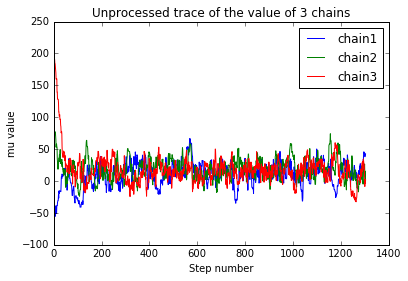

In [34]:
x = np.linspace(0, len(trace1) ,len(trace1))

plt.plot(x, trace1, label= "chain1")
plt.plot(x, trace2, label= "chain2")
plt.plot(x, trace3, label= "chain3")

print ('The gaussian acceptance for step length = ', step,' is ', acc )
print (np.mean(trace1), np.mean(trace2), np.mean(trace3))
plt.title("Unprocessed trace of the value of 3 chains")
plt.xlabel("Step number")
plt.ylabel("mu value")
plt.legend()

**Discarding the Burn-in phase**:

In [35]:
print (type(len(trace1)/2.))
trace1 = trace1[math.floor(len(trace1)/2):]
trace2 = trace2[math.floor(len(trace2)/2):]
trace3 = trace3[math.floor(len(trace3)/2):]
print (np.mean(trace1), np.mean(trace2), np.mean(trace3))

<class 'float'>
12.6648870635 20.1812316953 15.3177710163


**Plotting the reduced traces:**

The gaussian acceptance for step length =  10  is  0.7875766871165644
12.6648870635 20.1812316953 15.3177710163


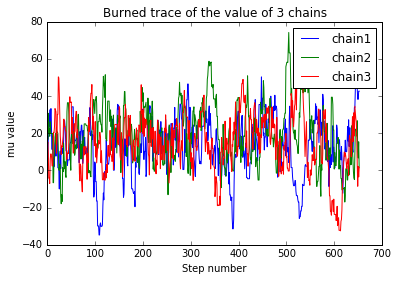

In [36]:
x = np.linspace(0, len(trace1) ,len(trace1))

plt.plot(x, trace1, label= "chain1")
plt.plot(x, trace2, label= "chain2")
plt.plot(x, trace3, label= "chain3")

print ('The gaussian acceptance for step length = ', step,' is ', acc )
print (np.mean(trace1), np.mean(trace2), np.mean(trace3))
plt.title("Burned trace of the value of 3 chains")
plt.xlabel("Step number")
plt.ylabel("mu value")
plt.legend()

**Thinning the traces:**

In [37]:
trace1 = trace1[0::10]
trace2 = trace2[0::10]
trace3 = trace3[0::10]

12.5302998127 19.5689084401 15.8665051961


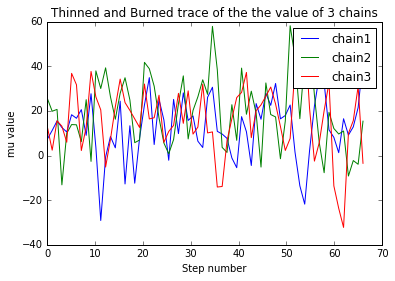

In [38]:
x = np.linspace(0, len(trace1) ,len(trace1))

plt.plot(x, trace1, label= "chain1")
plt.plot(x, trace2, label= "chain2")
plt.plot(x, trace3, label= "chain3")

print (np.mean(trace1), np.mean(trace2), np.mean(trace3))
plt.title("Thinned and Burned trace of the the value of 3 chains")
plt.xlabel("Step number")
plt.ylabel("mu value")
plt.legend()

**Plotting the reduced fit:**

The mean calculated value is:  15.9885711496


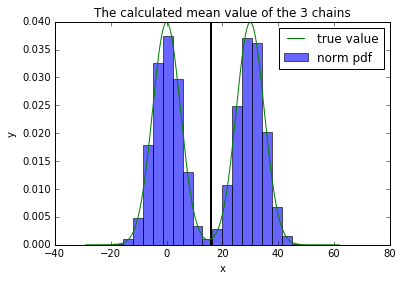

In [39]:
ax =  plt.subplot()
plt.hist(data, alpha=0.6, bins = 20, label='norm pdf', normed = True)
plt.title("Data distribution drawn from the true Gaussian")
plt.xlabel("X axis")
plt.ylabel("Count number")
mean = (np.mean(trace1) + np.mean(trace2) + np.mean(trace3))/3
w = np.linspace(min(data)-10,max(data)+10,n)
y = stats.norm(mean, sigma).pdf(w)/2
plt.axvline(x=mean, ymin=0, ymax = 1, linewidth=2, color='k')
plt.plot(w, stats.norm(mu_true,sigma).pdf(w)/2 + stats.norm(mu2,sigma2).pdf(w)/2, label="true value")
ax.set(xlabel = "x", ylabel = "y", title = "The calculated mean value of the 3 chains")
print ("The mean calculated value is: ", mean)
plt.legend()